# Graph analysis

## Data loading

In [1]:
%load_ext rpy2.ipython

import pandas

edges = pandas.read_csv('community.csv')
print(f'{len(edges.follower.unique())} nodes with {len(edges)} edges')
edges.head()

85323 nodes with 977735 edges


/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


,follower,followed
0,856150710936907777,1094637744754704384
1,513268026,1094637744754704384
2,2973520330,1094637744754704384
3,560318908,1094637744754704384
4,1057555594075389952,1094637744754704384


In [2]:
id_to_login = {
    1094637744754704384: 'Grenoble_Commun',
    1179020855323615233: 'GrenobleNvAir',
    1185172762287132672: 'Chalas2020',
    1222415322269044741: 'CommuneEstANous',
    722010413672636416: 'CarignonAlain',
    101776273: 'onoblecourt',
    1436327000: 'EmilieCChalas',
    1137353412: 'EricPiolle',
    2828047772: 'MireilledOrnano'
}
users = {
    'EricPiolle': 'Grenoble en Commun',
    'Grenoble_Commun': 'Grenoble en Commun',
    'EmilieCChalas': 'Un Nouveau Regard sur Grenoble',
    'Chalas2020': 'Un Nouveau Regard sur Grenoble',
    'CarignonAlain': 'Grenoble le Changement',
    'onoblecourt': 'Grenoble Nouvel Air',
    'GrenobleNvAir': 'Grenoble Nouvel Air',
    'CommuneEstANous': 'La commune est à nous !',
    'MireilledOrnano': 'Mieux vivre à Grenoble',
#    'YMongaburu': 'Grenoble en Commun',
#    'j_soldeville': 'Grenoble en Commun',
#    'pierremeriaux': 'Grenoble en Commun',
#    'marcsoulhol': 'La commune est à nous !',
#    'stephanegemmani': 'Grenoble Nouvel Air',
}
names = {
    'EricPiolle': 'Éric Piolle',
    'EmilieCChalas': 'Emilie Chalas',
    'CarignonAlain': 'Alain Carignon',
    'onoblecourt': 'Olivier Noblecourt',
    'Grenoble_Commun': 'Grenoble en Commun',
    'Chalas2020': 'Un Nouveau Regard sur Grenoble',
    'GrenobleNvAir': 'Grenoble Nouvel Air',
    'CommuneEstANous': 'La commune est à nous !',
    'MireilledOrnano': "Mireille d'Ornano",
}
colors = {
    'Grenoble en Commun': '#00c000',
    'Un Nouveau Regard sur Grenoble': '#ffb400',
    'Grenoble le Changement': '#0066CC',
    'Grenoble Nouvel Air': '#ff8080',
    'La commune est à nous !': '#bb0000',
    'Mieux vivre à Grenoble': '#0D378A'
}
colors.update({usr: colors[tag] for usr, tag in users.items()})
from collections import defaultdict
colors = defaultdict(lambda: '#AAAAAA', colors)

color2 = {usr_id: colors[users[login]] for usr_id, login in id_to_login.items()}
color2

{1094637744754704384: '#00c000',
 1179020855323615233: '#ff8080',
 1185172762287132672: '#ffb400',
 1222415322269044741: '#bb0000',
 722010413672636416: '#0066CC',
 101776273: '#ff8080',
 1436327000: '#ffb400',
 1137353412: '#00c000',
 2828047772: '#0D378A'}

In [3]:
follower_files = [
    'followers/CarignonAlain.csv',
    'followers/EmilieCChalas.csv',
    'followers/onoblecourt.csv',
    'followers/EricPiolle.csv',
    'followers/MireilledOrnano.csv',
]

friend_files = [
    'friends/CarignonAlain.csv',
    'friends/EmilieCChalas.csv',
    'friends/onoblecourt.csv',
    'friends/EricPiolle.csv',
    'friends/MireilledOrnano.csv',
]

follower_files += [
    'followers_lists/Grenoble_Commun.csv',
    'followers_lists/GrenobleNvAir.csv',
    'followers_lists/Chalas2020.csv',
    'followers_lists/CommuneEstANous.csv',
]

friend_files += [
    'friends_lists/Grenoble_Commun.csv',
    'friends_lists/GrenobleNvAir.csv',
    'friends_lists/Chalas2020.csv',
    'friends_lists/CommuneEstANous.csv',
]

filenames = follower_files + friend_files

data = []
for f in filenames:
    login = f.split('/')[1].split('.')[0]
    relation = 'followers' if 'follower' in f else 'friends'
    tmp = pandas.read_csv(f)
    tmp['relation'] = relation
    tmp['candidate_login'] = login
    tmp['candidate_name'] = names[login]
    tmp['candidate_tag'] = users[login]
    data.append(tmp)
users = pandas.concat(data).reset_index(drop=True)

print(len(users), len(users.columns))
users.columns

68463 19


Index(['name', 'screen_name', 'date', 'description', 'followers_count',
       'following_count', 'statuses_count', 'likes_count',
       'default_background', 'default_avatar', 'verified', 'listed_count',
       'protected', 'id', 'location', 'relation', 'candidate_login',
       'candidate_name', 'candidate_tag'],
      dtype='object')

## Filtering - keeping only the users with Grenoble in their location

In [4]:
graph_ids = set(edges['follower']) | set(edges['followed'])
missing_ids = graph_ids - set(users['id'].unique())
print(f'{len(graph_ids)} ids, {len(missing_ids)} are unknown')

87047 ids, 31089 are unknown


In [5]:
import os
import csv
user_file = 'user_base.csv'
if os.path.isfile(user_file):
    print(f'Loading missing users from file {user_file}')
    new_users = pandas.read_csv(user_file)
else:
    print('Downloading missing users from twitter')
    import twitter
    new_users = twitter.ids_to_users(list(missing_ids))
    new_users = twitter.build_dataframe(new_users, twitter.user_to_dict)
    new_users.to_csv(user_file, index=False, quoting=csv.QUOTE_ALL)
print(f'User base of {len(new_users)} users')
users = pandas.concat([users, new_users])

Loading missing users from file user_base.csv
User base of 31073 users


In [6]:
missing_ids = graph_ids - set(users['id'].unique())
print(f'{len(graph_ids)} ids, {len(missing_ids)} are unknown')

87047 ids, 16 are unknown


In [7]:
users.loc[users['location'].isna(), 'location'] = ''
grenoble_ids = set(users[users['location'].str.lower().str.contains('grenoble')]['id'].unique())
print(f'{len(grenoble_ids)} users with Grenoble in their location')
old_len = len(edges)
edges = edges[(edges['follower'].isin(grenoble_ids)) & (edges['followed'].isin(grenoble_ids))]
print(f'Keeping only the pairs of users that are both located in Grenoble')
print(f'{old_len} → {len(edges)}')

8672 users with Grenoble in their location
Keeping only the pairs of users that are both located in Grenoble
977735 → 234120


## First graph visualization

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()
G.add_edges_from([e for _, e in edges.drop_duplicates().iterrows()])
print(f'{len(G)} nodes with {len(G.edges)} edges')

8665 nodes with 234120 edges


In [9]:
degrees = pandas.DataFrame([{'node': node, 'degree': deg} for node, deg in G.degree()])
degrees.columns = ['id', 'degree']
degrees = degrees.set_index('id')
tmp = users[['id', 'screen_name']].drop_duplicates().set_index('id')
degrees['login'] = tmp['screen_name']
degrees.sort_values(by='degree', ascending=False).head(n=20)

,degree,login
id,,
83113955,6669,VilledeGrenoble
1137353412,4215,EricPiolle
1068423768,3216,LeDL_Grenoble
194191469,3016,f3Alpes
1307113646,2341,placegrenet
487582647,2340,EchoSciGre
773862752,2261,FCGrugby
17731812,2171,GreNews_CLN
604330177,2116,FabienMalbet


In [10]:
mutuals = G.to_undirected(reciprocal=True)
print(f'{len(mutuals)} nodes with {len(mutuals.edges)} edges')

8665 nodes with 40331 edges


In [11]:
def trim_degrees(g, degree=1, keep=[]):
    keep = set(keep)
    g = g.copy()
    low_degrees = [node for node, deg in g.degree() if deg < degree and node not in keep]
    print(f'Removing {len(low_degrees)} nodes')
    g.remove_nodes_from(low_degrees)
    return g

In [12]:
def rec_trim(g, degree, n, keep):
    if n == 0 or degree == 0:
        return g
    else:
        trimed = trim_degrees(g, degree, keep)
        if len(trimed) == len(g):
            return trimed
        return rec_trim(trimed, degree, n-1, keep)

In [13]:
pruned = rec_trim(mutuals, degree=30, n=20, keep=list(id_to_login))
print(f'{len(pruned)} nodes with {len(pruned.edges)} edges')

Removing 7987 nodes
Removing 210 nodes
Removing 68 nodes
Removing 36 nodes
Removing 25 nodes
Removing 17 nodes
Removing 11 nodes
Removing 8 nodes
Removing 5 nodes
Removing 7 nodes
Removing 5 nodes
Removing 4 nodes
Removing 7 nodes
Removing 5 nodes
Removing 2 nodes
Removing 3 nodes
Removing 5 nodes
Removing 4 nodes
Removing 2 nodes
Removing 2 nodes
252 nodes with 7831 edges


In [14]:
def build_basic_communities(graph):
    communities = {}
    for node in graph:
        if node in id_to_login:
            continue
        commu = None
        for other in id_to_login:
            if (node, other) in graph.edges:
                pos_commu = color2[other]
                if commu is None:
                    commu = pos_commu
                elif commu != pos_commu:
                    commu = '#000000'
        if commu is None:  # possible if the node is followed by one of the candidates but does not follow them
            commu = '#000000'
        communities[node] = commu
    return communities

communities = build_basic_communities(G)

In [15]:
print(len([col for col in communities.values() if col == '#000000']))
print(len([col for col in communities.values() if col != '#000000']))

5393
3263


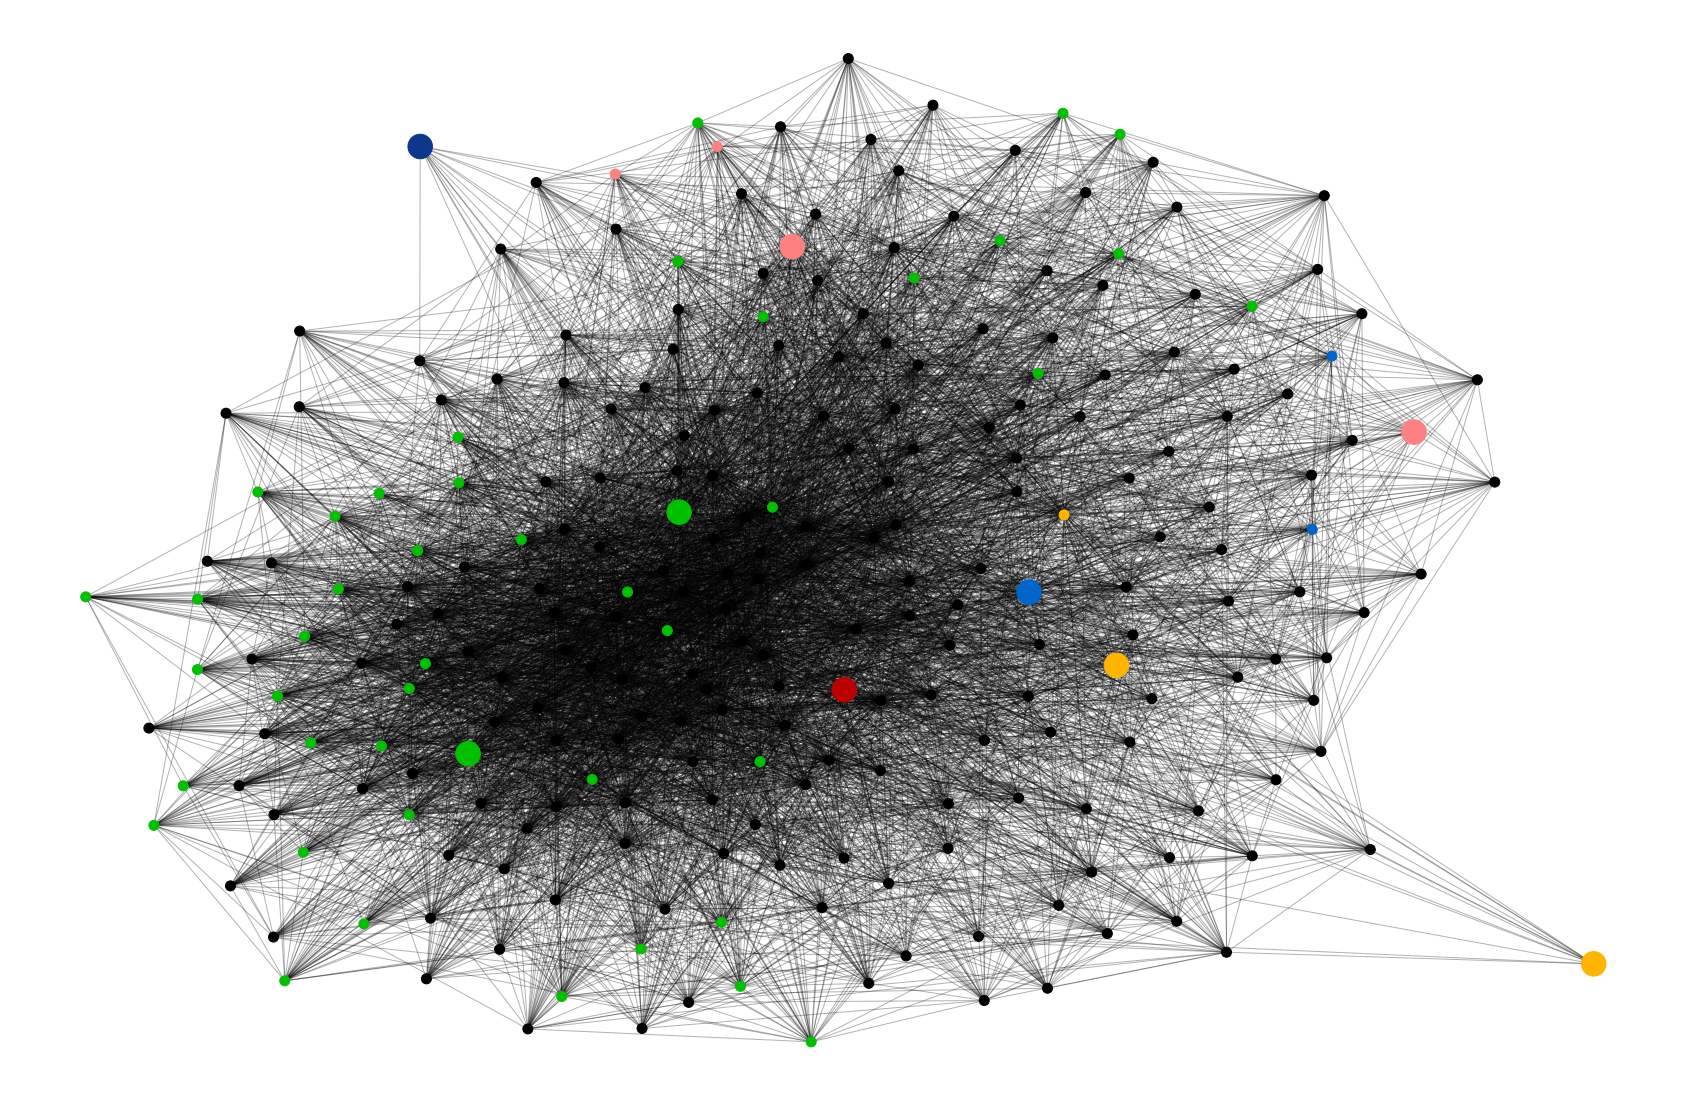

In [16]:
pos = nx.spring_layout(pruned, k=0.5, iterations=1000)  # compute graph layout
plt.figure(figsize=(30, 20))
plt.axis('off')
main_nodes = list(id_to_login)
main_colors = list(color2[node] for node in main_nodes)
other_nodes = list(set(pruned)-set(main_nodes))
other_colors = [communities[node] for node in other_nodes]
nx.draw_networkx_nodes(other_nodes, pos, node_size=100, node_color=other_colors)#, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_nodes(main_nodes, pos, node_size=600, node_color=main_colors)
#nx.draw_networkx_labels(labels={1137353412:'EP'})
nx.draw_networkx_edges(pruned, pos, alpha=0.3)
plt.show(pruned)

## Finding communities

This one does not work so well. The result (number of communities and which community is assigned to each candidate) changes significantly each time I use another minimal degree in `rec_trim`, but also from run to run with the same minimal degree (because of the randomness in the algorithm). So, not very useful.

In [17]:
import community # python-louvain package

In [18]:
pruned = rec_trim(mutuals, degree=5, n=20, keep=list(id_to_login))
print(f'{len(pruned)} nodes with {len(pruned.edges)} edges')

Removing 6119 nodes
Removing 144 nodes
Removing 34 nodes
Removing 8 nodes
Removing 2 nodes
Removing 2 nodes
Removing 3 nodes
Removing 1 nodes
Removing 0 nodes
2352 nodes with 35287 edges


In [19]:
partition = community.best_partition(pruned)
print(f'Found {len(set(partition.values()))} communities')

Found 8 communities


In [20]:
for idusr, usr in id_to_login.items():
    print(usr, partition[idusr])

Grenoble_Commun 0
GrenobleNvAir 4
Chalas2020 0
CommuneEstANous 0
CarignonAlain 0
onoblecourt 4
EmilieCChalas 0
EricPiolle 0
MireilledOrnano 0


In [21]:
degrees = pandas.DataFrame([{'node': node, 'degree': deg, 'community': partition[node]} for node, deg in pruned.degree()])
degrees.columns = ['id', 'degree', 'community']
degrees = degrees.set_index('id')
tmp = users[['id', 'screen_name']].drop_duplicates().set_index('id')
degrees['login'] = tmp['screen_name']
degrees.sort_values(by='degree', ascending=False).head(n=20)

,degree,community,login
id,,,
487582647,680,3,EchoSciGre
604330177,548,0,FabienMalbet
402980505,509,0,EveMoulinier
704607010055032832,462,4,Gre1jour1photo
184069308,420,0,j_soldeville
1137353412,402,0,EricPiolle
362696910,364,0,marcsoulhol
1316388883,355,4,ResCitoyen
8627342,329,4,stephanegemmani


In [22]:
degrees.groupby('community')[['degree']].agg(['count', 'sum']).sort_values(by=('degree', 'count'), ascending=False).head(n=10)

degree       
           count    sum
community              
1            618  15392
0            559  23969
3            425  11453
4            354   9587
2            278   7442
6             86   2295
5             28    408
7              4     28

## Diameter and radius

In [23]:
pruned = rec_trim(mutuals, degree=3, n=20, keep=list(id_to_login))
print(f'{len(pruned)} nodes with {len(pruned.edges)} edges')

Removing 5376 nodes
Removing 141 nodes
Removing 24 nodes
Removing 10 nodes
Removing 4 nodes
Removing 3 nodes
Removing 2 nodes
Removing 2 nodes
Removing 1 nodes
Removing 0 nodes
3102 nodes with 37790 edges


In [24]:
ecc = nx.eccentricity(pruned)

In [25]:
nx.diameter(pruned, e=ecc)

6

In [26]:
nx.radius(pruned, e=ecc)

4

## Pagerank

In [27]:
rank = nx.pagerank(G)

In [28]:
ranks = pandas.DataFrame([{'node': node, 'degree': deg, 'rank': rank[node]} for node, deg in G.degree()])
ranks.columns = ['id', 'degree', 'rank']
ranks = ranks.set_index('id')
tmp = users[['id', 'screen_name']].drop_duplicates().set_index('id')
ranks['login'] = tmp['screen_name']
ranks = ranks.reset_index()
ranks.sort_values(by='rank', ascending=False).head(n=10)

,id,degree,rank,login
461,83113955,6669,0.034097,VilledeGrenoble
271,1137353412,4215,0.014976,EricPiolle
460,1068423768,3216,0.013385,LeDL_Grenoble
37,194191469,3016,0.010620,f3Alpes
401,773862752,2261,0.009059,FCGrugby
612,17731812,2171,0.008311,GreNews_CLN
457,1307113646,2341,0.007842,placegrenet
1251,25069929,1534,0.007450,MisterVonline
417,587712377,1590,0.005914,TAG_Grenoble
437,4792564054,1580,0.005664,UGrenobleAlpes


In [29]:
ranks[ranks['id'].isin(set(id_to_login))].sort_values(by='rank', ascending=False).head(n=20)

,id,degree,rank,login
271,1137353412,4215,0.014976,EricPiolle
509,1436327000,572,0.001668,EmilieCChalas
522,101776273,486,0.001318,onoblecourt
195,722010413672636416,1126,0.001226,CarignonAlain
1,1094637744754704384,599,0.001046,Grenoble_Commun
462,1179020855323615233,296,0.000594,GrenobleNvAir
557,1185172762287132672,175,0.000411,Chalas2020
21,2828047772,154,0.000351,MireilledOrnano
31,1222415322269044741,235,0.000278,CommuneEstANous


In [30]:
def restrict_graph(g, nodes):
    keep = set(nodes)
    g = g.copy()
    to_remove = [node for node in g if node not in keep]
    print(f'Removing {len(to_remove)} nodes')
    g.remove_nodes_from(to_remove)
    return g

selected_nodes = set(ranks.sort_values(by='rank', ascending=False).head(n=100)['id']) | set(id_to_login)
tmp = restrict_graph(G, selected_nodes)
print(f'{len(tmp)} nodes with {len(tmp.edges)} edges')

Removing 8558 nodes
107 nodes with 4318 edges


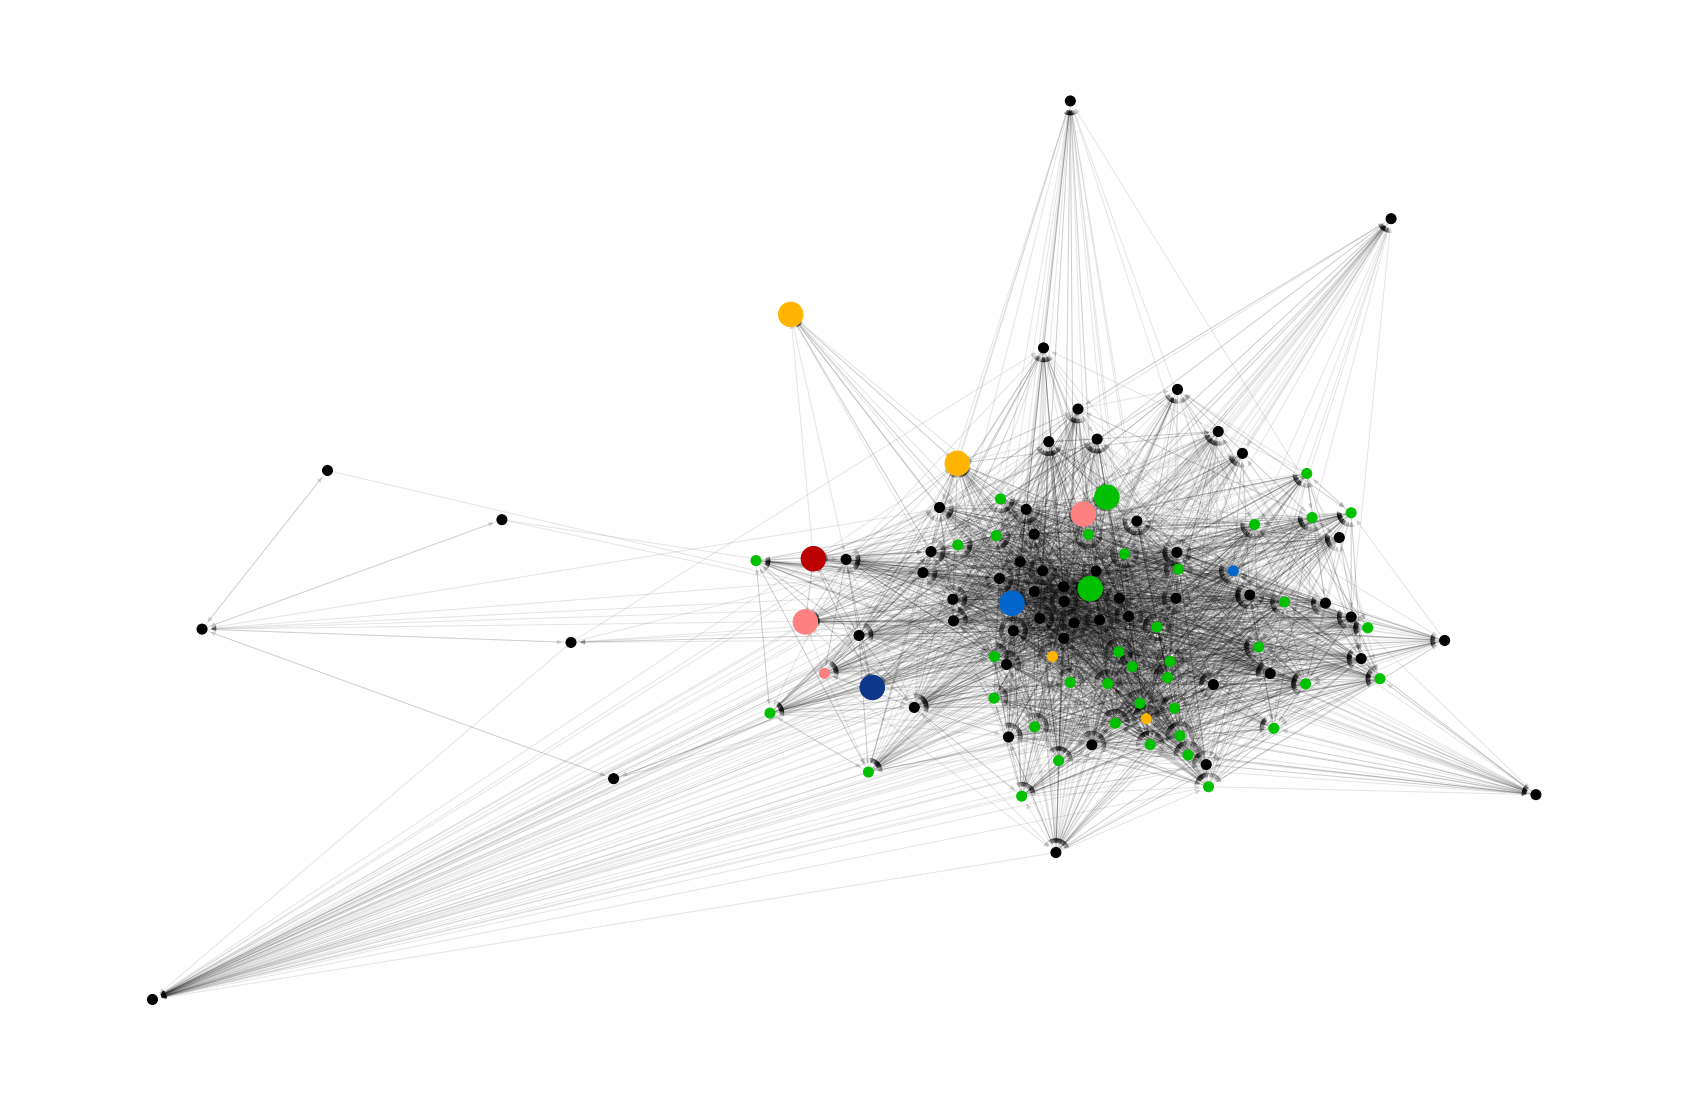

In [31]:
pos = nx.spring_layout(tmp, k=0.5, iterations=1000)  # compute graph layout
plt.figure(figsize=(30, 20))
plt.axis('off')
main_nodes = list(id_to_login)
main_colors = list(color2[node] for node in main_nodes)
other_nodes = list(set(tmp)-set(main_nodes))
other_colors = [communities[node] for node in other_nodes]
nx.draw_networkx_nodes(other_nodes, pos, node_size=100, node_color=other_colors)#, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_nodes(main_nodes, pos, node_size=600, node_color=main_colors)
#nx.draw_networkx_labels(labels={1137353412:'EP'})
nx.draw_networkx_edges(tmp, pos, alpha=0.1)
plt.show(tmp)

Removing 8656 nodes
9 nodes with 31 edges


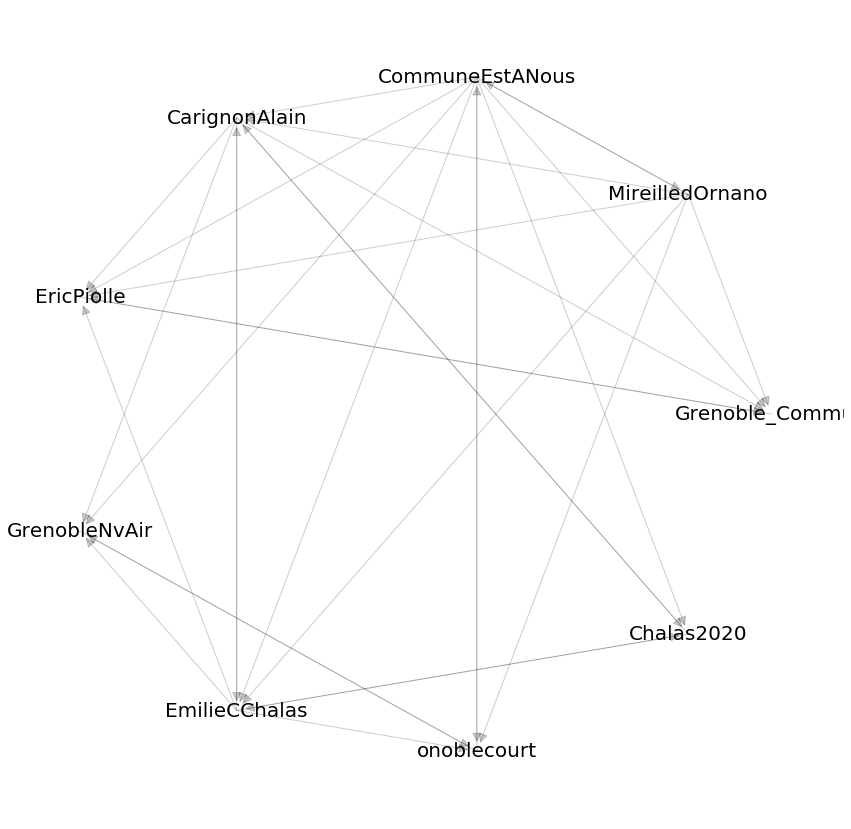

In [32]:
selection = ranks[ranks.id.isin(id_to_login)]
selected_nodes = set(selection['id'])
tmp = restrict_graph(G, selected_nodes)
tmp = nx.relabel_nodes(tmp, {row.id:row.login for _, row in selection.iterrows()})
print(f'{len(tmp)} nodes with {len(tmp.edges)} edges')

pos = nx.shell_layout(tmp)  # compute graph layout
plt.figure(figsize=(15, 15))
plt.axis('off')
other_nodes = list(set(tmp))
nx.draw_networkx_nodes(other_nodes, pos, node_size=1000, alpha=0)
nx.draw_networkx_edges(tmp, pos, width=1, arrowsize=20, alpha=0.2)
nx.draw_networkx_labels(tmp,pos, font_size=20)
plt.savefig('/tmp/relations.png')
plt.show(tmp)

In [33]:
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)

In [34]:
ranks['rank_percent'] = ranks['rank']*100
ranks['login'] = pandas.Categorical(ranks['login'], categories=ranks.sort_values(by='rank')['login'], ordered=True)

In [35]:
tmp = ranks.sort_values(by='rank', ascending=False).head(n=40)[['login', 'rank_percent']].reset_index(drop=True)
tmp['color'] = tmp.apply(lambda row: colors[row.login], axis=1)
tmp.head()

,login,rank_percent,color
0,VilledeGrenoble,3.409723,#AAAAAA
1,EricPiolle,1.497639,#00c000
2,LeDL_Grenoble,1.338543,#AAAAAA
3,f3Alpes,1.061965,#AAAAAA
4,FCGrugby,0.905915,#AAAAAA


R[write to console]: 
Attachement du package : ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




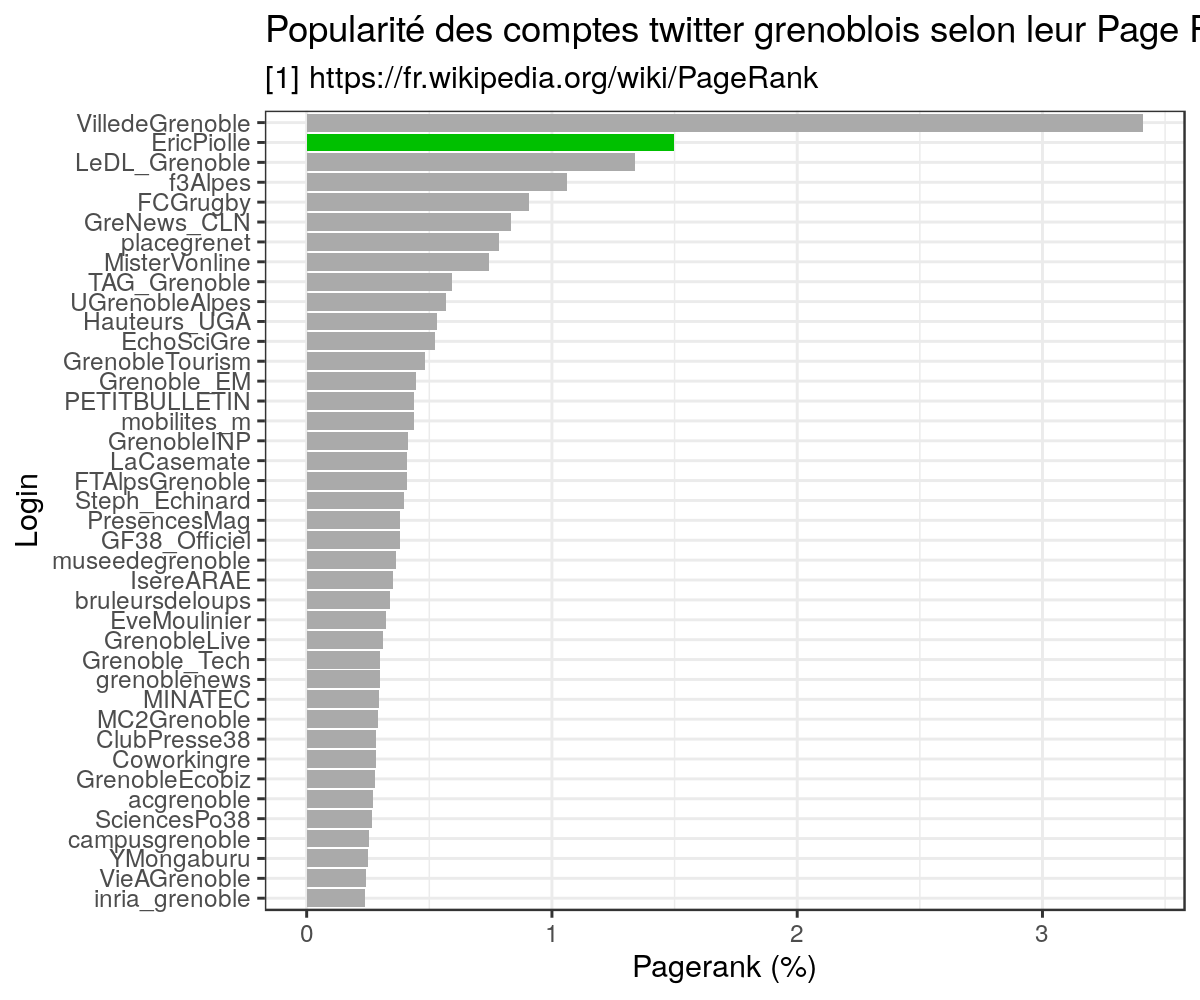

In [36]:
%%R -i tmp -w 6 -h 5 --units in -r 200

library(ggplot2)
library(dplyr)

do_plot <- function(df) {
    plot = ggplot(df) +
        aes(x=login, y=rank_percent, fill=login) +
        geom_bar(stat='identity') +
        scale_fill_manual(values = df$color, limits=as.character(df$login)) +
        theme_bw() +
        theme(legend.position='none') +
        coord_flip() +
        ylab('Pagerank (%)') +
        xlab('Login') +
        labs(title='Popularité des comptes twitter grenoblois selon leur Page Rank[1]') +
        labs(subtitle='[1] https://fr.wikipedia.org/wiki/PageRank')
    return(plot)
}

plot = do_plot(tmp)
ggsave('/tmp/pagerank.png', plot, width=7, height=6)
ggsave('/tmp/figures/9.pdf', plot, width=8, height=4.5)
plot

In [37]:
tmp = ranks[ranks['id'].isin(set(id_to_login))].reset_index(drop=True)[['login', 'rank_percent']]
tmp['color'] = tmp.apply(lambda row: colors[row.login], axis=1)
tmp['text'] = round(tmp['rank_percent'], 2)
tmp['text'] = tmp['text'].astype(str) + '%'
tmp.head()

,login,rank_percent,color,text
0,Grenoble_Commun,0.104629,#00c000,0.1%
1,MireilledOrnano,0.035106,#0D378A,0.04%
2,CommuneEstANous,0.027767,#bb0000,0.03%
3,CarignonAlain,0.122648,#0066CC,0.12%
4,EricPiolle,1.497639,#00c000,1.5%


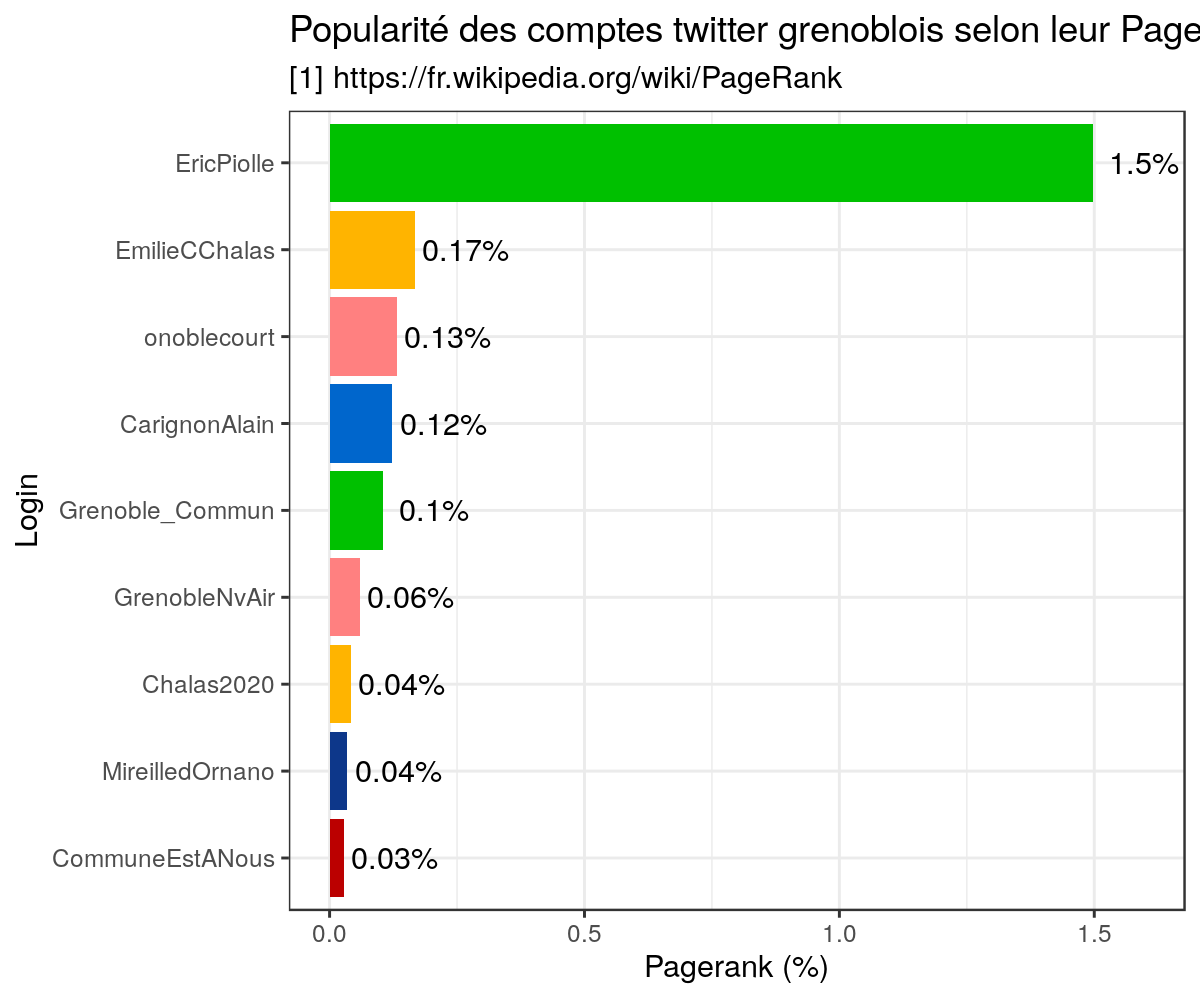

In [38]:
%%R -i tmp -w 6 -h 5 --units in -r 200

tmp$y_text = tmp$rank_percent
plot = do_plot(tmp) + geom_text(aes(label=text, y=y_text), position=position_nudge(y=0.1))
ggsave('/tmp/pagerank_candidat.png', plot, width=7, height=6)
ggsave('/tmp/figures/10.pdf', plot, width=8, height=4.5)
plot

/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/plotnine/scales/scale_manual.py:27: PlotnineWarning: Palette can return a maximum of 54 values. 8665 were requested from it.
  warn(msg.format(max_n, n), PlotnineWarning)
/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/plotnine/scales/scale_manual.py:27: PlotnineWarning: Palette can return a maximum of 508 values. 8665 were requested from it.
  warn(msg.format(max_n, n), PlotnineWarning)


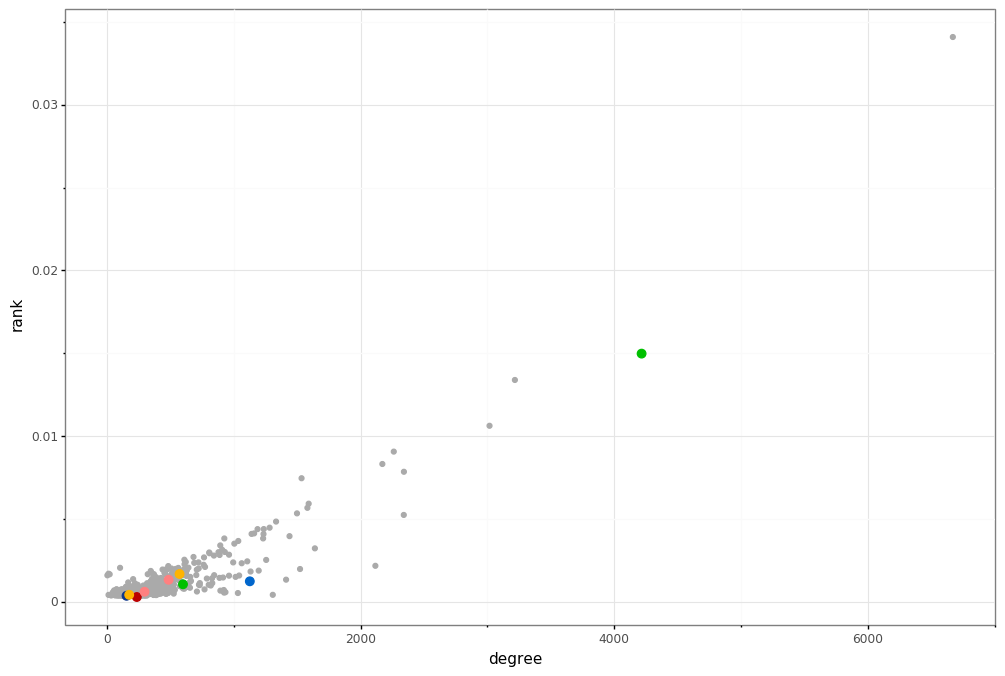

<ggplot: (8763073792113)>

In [39]:
plot = ggplot(ranks[ranks['id'].isin(id_to_login)]) +\
    aes(x='degree', y='rank', color='login') +\
    geom_point(ranks.sort_values(by='rank', ascending=False).head(n=500).tail(n=500)) +\
    geom_point(size=3) +\
    scale_color_manual(colors) +\
    theme_bw() +\
    theme(legend_position='none')
plot